<br>

### Import Librarires

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import torch
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
from pycocotools.coco import COCO

import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

<br><br>

### Custom Dataset Class

In [3]:
# Custom PyTorch Dataset to load COCO-format annotations and images
class CocoSegmentationDataset(Dataset):
    # Init function: loads annotation file and prepares list of image id's
    def __init__(self, root_dir, annotation_file, transforms=None):
        """
        root_dir: path to the folder containing images (e.g. car_parts_dataset/train/)
        annotation_file: path to the COCO annotations (e.g. car_parts_dataset/train/_annotations.coco.json)
        """
        self.root_dir = root_dir  # Directory where images are stored
        self.coco = COCO(annotation_file)  # Load COCO annotations
        self.image_ids = list(self.coco.imgs.keys())  # Extract all image IDs
        self.transforms = transforms  # Optional image transformations
     
    # Returns total number of images
    def __len__(self):
        return len(self.image_ids)  # Total number of images
 
    # Fetches a single image and its annotations
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]  # Get image ID from list
        image_info = self.coco.loadImgs(image_id)[0]  # Load image info (e.g. filename)
        image_path = os.path.join(self.root_dir, image_info["file_name"])  # Construct full path
        image = Image.open(image_path).convert("RGB")  # Load and convert image to RGB
         
        # Load all annotations for this image
        annotation_ids = self.coco.getAnnIds(imgIds=image_id)  # Get annotation IDs for image
        annotations = self.coco.loadAnns(annotation_ids)  # Load annotation details
         
        # Extract segmentation masks, bounding boxes and labels from annotations
        boxes = []  # List to store bounding boxes
        labels = []  # List to store category labels
        masks = []  # List to store segmentation masks
         
        for ann in annotations:
            xmin, ymin, w, h = ann['bbox']  # Get bounding box in COCO format (x, y, width, height)
            xmax = xmin + w  # Calculate bottom-right x
            ymax = ymin + h  # Calculate bottom-right y
            boxes.append([xmin, ymin, xmax, ymax])  # Append box in (xmin, ymin, xmax, ymax) format
            labels.append(ann['category_id'])  # Append category ID
            mask = self.coco.annToMask(ann)  # Convert segmentation to binary mask
            masks.append(mask)  # Append mask
         
        # Convert annotations to PyTorch tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)  # Bounding boxes as float tensors
        labels = torch.as_tensor(labels, dtype=torch.int64)  # Labels as int64 tensors
        masks = torch.as_tensor(masks, dtype=torch.uint8)  # Masks as uint8 tensors
        area = torch.as_tensor([ann['area'] for ann in annotations], dtype=torch.float32)  # Area of each object
        iscrowd = torch.as_tensor([ann.get('iscrowd', 0) for ann in annotations], dtype=torch.int64)  # Crowd annotations
         
        # store everything in a dictionary
        target = {
            "boxes": boxes,  # Bounding boxes
            "labels": labels,  # Object labels
            "masks": masks,  # Segmentation masks
            "image_id": image_id,  # Image ID
            "area": area,  # Area of each object
            "iscrowd": iscrowd  # Crowd flags
        }
 
        # Apply transforms
        if self.transforms:
            image = self.transforms(image)  # Apply any data augmentations or preprocessing
         
        # Return the processed image and its annotations
        return image, target  # Return tuple of image and annotation dictionary

<br>

### Transforms

In [4]:
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
 
# Transform PIL image --> PyTorch tensor
def get_transform():
    return ToTensor()
 
# Load training dataset
train_dataset = CocoSegmentationDataset(
    root_dir='car_parts_dataset/train',
    annotation_file='car_parts_dataset/train/_annotations.coco.json',
    transforms=get_transform()  # define this if needed
)
 
# Load validation dataset
valid_dataset = CocoSegmentationDataset(
    root_dir='car_parts_dataset/valid',
    annotation_file='car_parts_dataset/valid/_annotations.coco.json',
    transforms=get_transform()
)
 

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [5]:
from torch.utils.data import DataLoader

# Load dataset with DataLoaders, you can change batch_size. DataLoader is used to load data in batches.
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [7]:
CLASS_NAMES = ["",
    "back_bumper", "back_glass", "back_left_door", "back_left_light", "back_right_door",
    "back_right_light", "front_bumper", "front_glass", "front_left_door", "front_left_light",
    "front_right_door", "front_right_light", "hood", "left_mirror", "right_mirror",
    "tailgate", "trunk", "wheel"
]

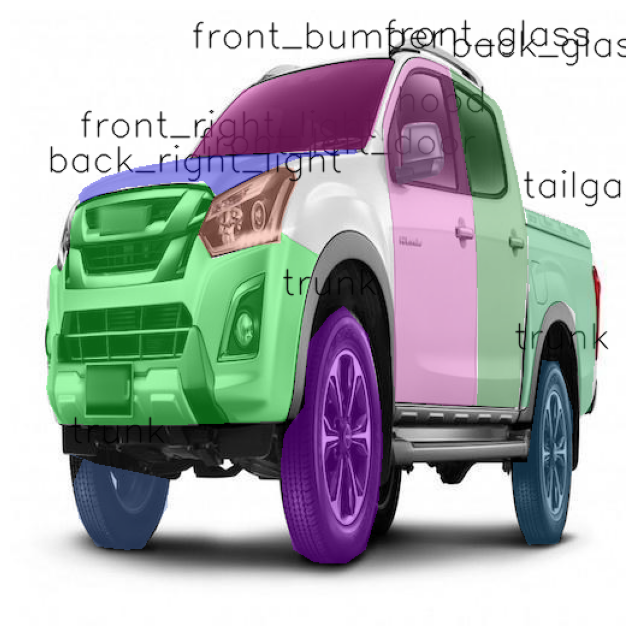

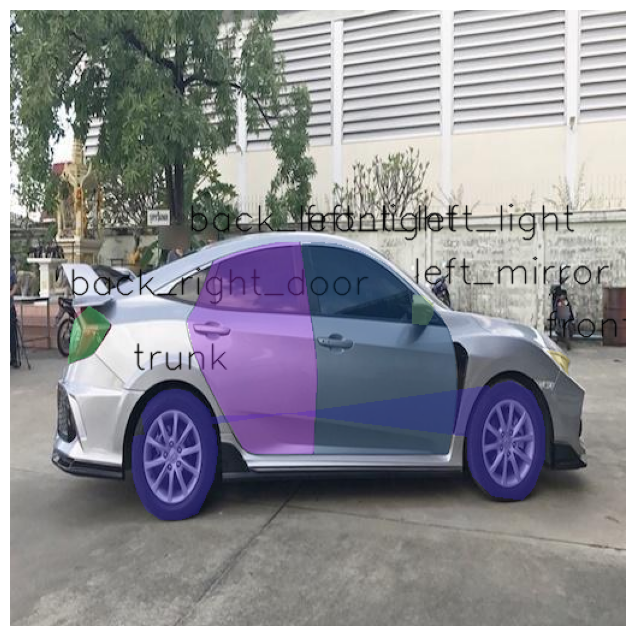

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Sample a batch
images, targets = next(iter(train_loader))

for i in range(len(images)):
    image = images[i].permute(1, 2, 0).cpu().numpy()
    image = (image * 255).astype(np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    overlay = image.copy()

    masks = targets[i]['masks'].cpu().numpy()
    boxes = targets[i]['boxes'].cpu().numpy()
    labels = targets[i]['labels'].cpu().numpy()

    for j in range(len(masks)):
        mask = masks[j]
        box = boxes[j]
        label_id = labels[j]

        # Get class name from mapping
        class_name = CLASS_NAMES[label_id - 1]  # assuming 1-based labels

        # Random color
        color = np.random.randint(0, 255, (3,), dtype=np.uint8).tolist()

        # Alpha blend mask
        colored_mask = np.zeros_like(image, dtype=np.uint8)
        for c in range(3):
            colored_mask[:, :, c] = mask * color[c]
        alpha = 0.4
        overlay = np.where(mask[..., None], 
                           ((1 - alpha) * overlay + alpha * colored_mask).astype(np.uint8), 
                           overlay)

        # Draw label
        x1, y1, x2, y2 = map(int, box)
        cv2.putText(overlay, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    1, (0,0,0), 1, lineType=cv2.LINE_AA)


    # Show the result
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.savefig("test.jpg")
    plt.show()
     


In [9]:
import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
 
# Load a pre-trained Mask R-CNN model with a ResNet-50 FPN backbone
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
 
# Determine the number of classes (including background) from training dataset
# COCO format includes category IDs, and we add +1 for background
num_classes = len(train_dataset.coco.getCatIds()) + 1
 
# Replace the existing box predictor with a new one for our number of classes
# in_features_box: number of input features to the classification layer
in_features_box = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features_box, num_classes) # classification and bounding box regression head
 
# Replace the existing mask predictor with a new one for our number of classes
# in_features_mask: number of input channels to the first convolutional layer 
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes) # mask prediction head
 
# Move the model to the specified device (e.g., GPU) for training or inference
model.to(device)

c:\Users\sirom\miniconda3\envs\yolov8_custom\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sirom\miniconda3\envs\yolov8_custom\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [9]:
# Get parameters that require gradients (the model's trainable parameters)
params = [p for p in model.parameters() if p.requires_grad]

# Define the optimizer (Stochastic Gradient Descent) with learning rate, momentum, and weight decay
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)


In [44]:
from engine import train_one_epoch, evaluate

# Set the number of epochs for training
num_epochs = 10

# Loop through each epoch
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Train the model for one epoch, printing status every 25 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=25)  # Using train_loader for training

    # Evaluate the model on the validation dataset
    evaluate(model, val_loader, device=device)  # Using val_loader for evaluation

    # Optionally, save the model checkpoint after each epoch
    torch.save(model.state_dict(), f"models/model_epoch_{epoch + 1}.pth")


Epoch 1/10
Epoch: [0]  [  0/190]  eta: 0:04:28  lr: 0.000031  loss: 5.1272 (5.1272)  loss_classifier: 2.8253 (2.8253)  loss_box_reg: 0.3372 (0.3372)  loss_mask: 1.5792 (1.5792)  loss_objectness: 0.3422 (0.3422)  loss_rpn_box_reg: 0.0432 (0.0432)  time: 1.4142  data: 0.5344  max mem: 2158
Epoch: [0]  [ 25/190]  eta: 0:03:16  lr: 0.000692  loss: 3.0189 (3.6489)  loss_classifier: 1.2232 (1.6505)  loss_box_reg: 0.7121 (0.6204)  loss_mask: 0.8926 (1.0980)  loss_objectness: 0.1042 (0.2353)  loss_rpn_box_reg: 0.0366 (0.0446)  time: 1.1738  data: 0.5567  max mem: 2470
Epoch: [0]  [ 50/190]  eta: 0:02:48  lr: 0.001353  loss: 2.4013 (3.0507)  loss_classifier: 0.9193 (1.2974)  loss_box_reg: 0.7409 (0.6771)  loss_mask: 0.6573 (0.8872)  loss_objectness: 0.0433 (0.1476)  loss_rpn_box_reg: 0.0338 (0.0414)  time: 1.2206  data: 0.5819  max mem: 2508
Epoch: [0]  [ 75/190]  eta: 0:02:19  lr: 0.002014  loss: 2.2388 (2.7924)  loss_classifier: 0.8606 (1.1549)  loss_box_reg: 0.8301 (0.7132)  loss_mask: 0.52

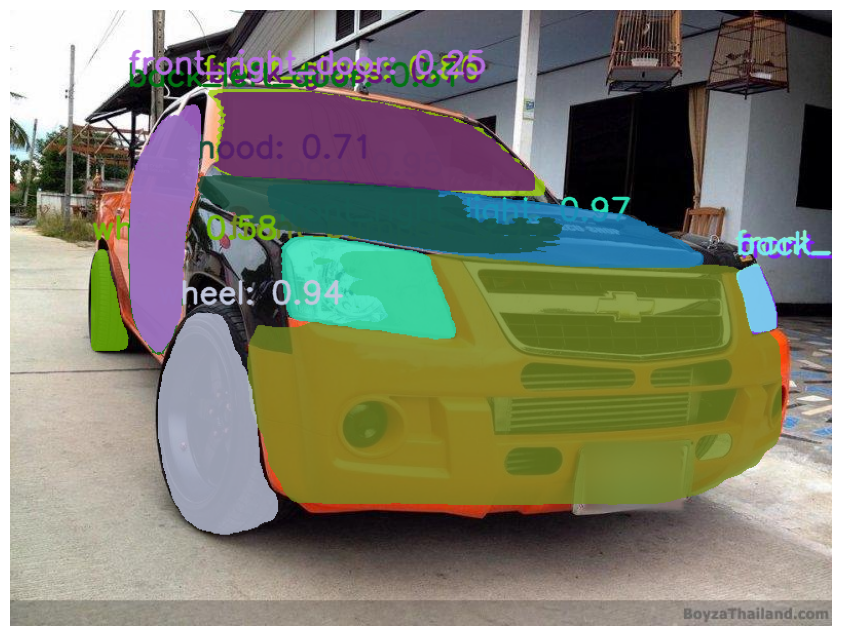

In [ ]:
import torch
from torchvision import transforms, models

# Load Mask R-CNN model with correct number of classes
model = models.detection.maskrcnn_resnet50_fpn(pretrained=False, num_classes=num_classes)

# Load your trained weights
model.load_state_dict(torch.load(r"models\model_epoch_10.pth"))
model.eval()

# Load image with OpenCV and convert to RGB
img_path = r"car_parts_dataset\valid\te97_jpg.rf.2dc52a8ff294140cc10ecc05d0b879ce.jpg"  # Change this path
image_bgr = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_pil = Image.fromarray(image_rgb)

# Transform image to tensor and add batch dimension
transform = transforms.Compose([transforms.ToTensor()])
image_tensor = transform(image_pil).unsqueeze(0)

# Inference
with torch.no_grad():
    predictions = model(image_tensor)

# Extract masks, boxes, labels, and scores
masks = predictions[0]['masks']       # [N, 1, H, W]
boxes = predictions[0]['boxes']
labels = predictions[0]['labels']
scores = predictions[0]['scores']

threshold = 0.2  # Confidence threshold

# Use overlay for blending masks over image
overlay = image_bgr.copy()

for i in range(len(masks)):
    if scores[i] > threshold:
        # Convert mask to uint8 numpy array (H,W)
        mask = masks[i, 0].mul(255).byte().cpu().numpy()
        mask_bool = mask > 127  # binary mask for indexing
        box = boxes[i].cpu().numpy().astype(int)
        class_name = CLASS_NAMES[labels[i]]
        score = scores[i].item()

        # Generate random color (BGR)
        color = np.random.randint(0, 255, (3,), dtype=np.uint8).tolist()

        # Create colored mask with the random color
        colored_mask = np.zeros_like(image_bgr, dtype=np.uint8)
        for c in range(3):
            colored_mask[:, :, c] = mask_bool * color[c]

        # Alpha blend the colored mask onto the overlay
        alpha = 0.4
        overlay = np.where(mask_bool[:, :, None],
                           ((1 - alpha) * overlay + alpha * colored_mask).astype(np.uint8),
                           overlay)

        # Draw bounding box and label text on overlay
        x1, y1, x2, y2 = box
        cv2.putText(overlay, f"{class_name}: {score:.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, lineType=cv2.LINE_AA)
        

# Show the result using matplotlib (convert BGR -> RGB)
result_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,8))
plt.imshow(result_rgb)
plt.axis('off')
plt.savefig("result.png")
plt.show()

<br><br><br>